# Visualizing Activation Responses of CNN Layers 

Visualizing filter raw weights is largely effective for only layers near the original input. A more general approach to understand what the network learns is to investigaete layer activation responses. Those responses, commonly seen as the transitional image representations in the network, give a sense of what features each layer picks up from the input. It is not only more trackable but also visually appealing than plotting raw weights. 

Recall an activation map is given by 
$$ h_{i}\; =\;  activation(\; W_{i}^{i-1}h_{i-1}\; +\; b_{i}\; ) $$  
where $h_{i},\; h_{i-1}\;$ are simply outputs from layer i and i-1.  

So, to plot layer activation responses, all we need are intermediate outputs from layers within a forward-pass. 

## Instantiate VGG16 model 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=False, weights='imagenet')

With the "include_top=False" argument, the model chops off the top fully connected layers and only preserves convolutional layers, hence it will allow input images of any size (as in the model summary, the second and the third dimension from the layer output shape are None).

Such practice also allows reusing or adapting the trained convolutional part of the network to other tasks (transfer learning), it will be covered later.

In [3]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Example to preprocess image

Before feeding images into the network, it's a good idea to preprocess them 

Here we use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html"> np.expand_dims( ) </a> to convert an image to a 4D array including the batch size dimension,   
and use Keras's built-in helper function <a href="https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py"> preprocess_input( ) </a> to switch channel formats and zero-center the pixels

(1, 224, 224, 3)


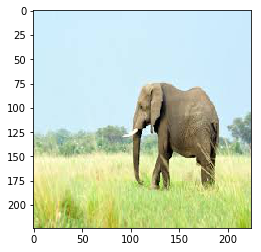

In [32]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input 

img_path = 'elephant.jpeg'    # default in the current folder
# use "target_size" argument to resize the image
# not necessary for the chopped off VGG16 model we are using, but may be useful for other models
img = image.load_img(img_path, target_size=(224, 224))   

x = image.img_to_array(img)      # convert image object to numpy arrays
x = np.expand_dims(x, axis=0)    # expand image dimension for batch size
x = preprocess_input(x)

print(x.shape)                   # double check image shape 
plt.imshow(img)

## Generate line images 

For simplicity, we will generate images of straight lines with different slopes and use them as inputs to visualize activation maps.  

*** You are welcome to use or generate your own images :) ***

### example to draw a line 
#### refer to http://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.line_aa

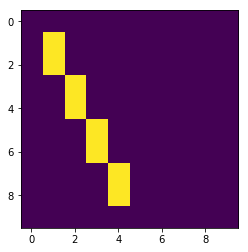

In [55]:
import scipy.misc 
from skimage.draw import line, line_aa

img = np.zeros((10, 10), dtype=np.uint8)
rr, cc = line(1, 1, 8, 4)
img[rr, cc] = 1
plt.imshow(img)

### helper function to show images

In [54]:
def show_images(images):
    """ show an array of images 
    """
    size = images.shape[0]
    plt.figure(figsize=(20,20))
    for i in range(size):
        plt.subplot(1, size, i+1)
        plt.imshow(images[i])
    plt.show()

### generate line images by start & end points

In [53]:
def is_in_range(interval, val):
    """ check if the value is in the interval [lower_bound, upperbound)
    """
    return (interval[0] <= val) and (val < interval[1])

def is_point_in_range(zone, point):
    """ check if the point is in the zone 
    """
    return is_in_range((0, zone[0]), point[0]) and is_in_range((0, zone[1]), point[1])

def generate_line_image(shape, start, end):
    """ generate an image/array of a line
    
    Args:
        shape: dimensions of the image.
        start: a tuple of the starting point.
        end: a tuple of the end point.
        
    Returns:
        numpy array as a image of a line 
    """
    if is_point_in_range(shape, start) and is_point_in_range(shape, end):
        img = np.zeros(shape=shape, dtype=np.uint8)
        rr, cc, val = line_aa(start[0], start[1], end[0], end[1])
        img[rr, cc] = val * 255
        # return img
        return np.dstack((img,)*3) 
    
def generate_line_image_batch(size, shape, start_list, end_list):
    """ generate a batch of line images stacked in a numpy array 
    
    Args:
        size: batch size/number of images to generate.
        shape: dimensions of the image.
        start_list: a list of starting points.
        end_list: a list of end points
        
    Returns:
        numpy array of image stack
    """
    batch = []
    for i in range(size):
        img = generate_line_image(shape, start_list[i], end_list[i])
        batch.append(img)
        
    batch = np.array(batch)
    return batch 

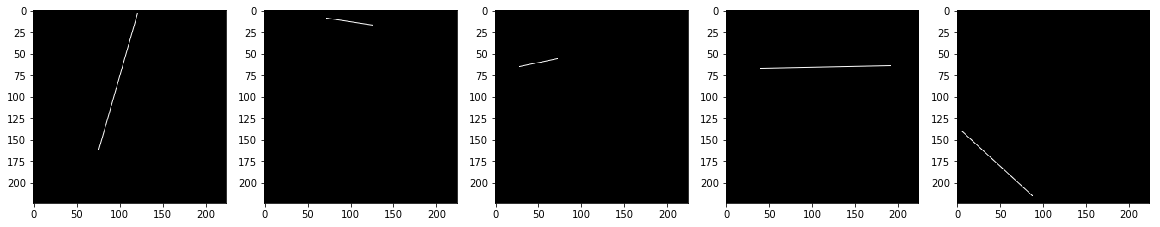

In [50]:
#Test
start_list = [(np.random.randint(224), np.random.randint(224),) for i in range(5)]
end_list = [(np.random.randint(224), np.random.randint(224),) for i in range(5)]

batch = generate_line_image_batch(5, (224, 224), start_list, end_list)
show_images(batch)

### generate line images by slope/degree

In [52]:
def degree2line(shape, degree):
    """generate starting point and end point.
    
    Args:
        shape: image dimensions in 2D.
        degree: slope of the line.
        
    Returns:
        a tuple of two tuples for the starting point and end point 
    """
    row = shape[0]
    col = shape[1]
    if degree == 0:
        return ((int(row/2), int(col/4)), (int(row/2), 3*int(col/4)))
    elif degree == 45:
        return ((int(row/4), int(col/4)), (3*int(row/4), 3*int(col/4)))
    elif degree == 90:
        return ((int(row/4), int(col/2)), (3*int(row/4), int(col/2)))
    elif degree == 135:
        return ((int(row/4), 3*int(col/4)), (3*int(row/4), int(col/4)))
    else:
        return ((int(row/2), int(col/4)), (int(row/2), 3*int(col/4)))

def generate_line_image_batch_by_degree(size, shape, degrees):
    """ generate line images by degree.
    """
    points = [degree2line(shape, degree) for degree in degrees]
    start_points = [item[0] for item in points]
    end_points = [item[1] for item in points]
    return generate_line_image_batch(size, shape, start_points, end_points)

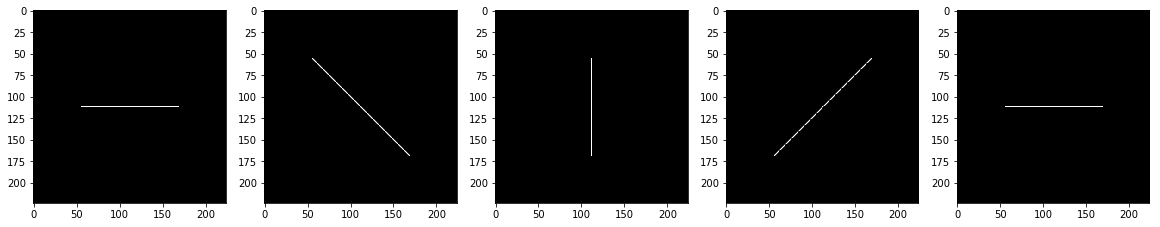

In [51]:
# Test 
line_batch = generate_line_image_batch_by_degree(5, (224,224), [0, 45, 90, 135, 180])
show_images(line_batch)

## Retrieve activation responses 

Keras provides high-level wrappers for various TensorFlow operations. But a Keras model does not store the intermediate computations of a forward pass. In order to get the activation responses of different layers, we could define a new model stopping at a specific layer and get the output by doing a forward passe.    

Alternatively, we could use the Keras <a href="https://keras.io/backend/"> backend </a> to customized our operations while maintaining the ease-of-use brought by Keras. Keras supports both TensorFlow and Theano as its backend, by default we are using TensorFlow but it could be configured in the .kears config file. 

In [59]:
from keras import backend as K

def get_layer_output_function(model, layer_dict, layer):
    return K.function([model.layers[0].input, K.learning_phase()],[layer_dict[layer].output])

<a href="https://keras.io/backend/"> K.function( inputs, outputs ) </a> returns a Python function implemented with Keras's backend  
- ***input***: input to the returned function, "model.layers[0]" here to indicate we always feed in the original image, "K.learning_phase()" to indicate whether it's in training or testing stage. 
- ***output***: output to the returned function, derived based on the computational graph defined and the input. "layer_dict[layer].output" here for the specified layer output we want.

In [60]:
# Test
# create a function to retrieve output (activation) from the "block2_conv2" layer.
get_layer_output = get_layer_output_function(model, layer_dict, "block2_conv2")
layer_output = get_layer_output([line_batch, 0])[0]

print(layer_output.shape)    # validate layer output 

(5, 112, 112, 128)


visualize the activation map

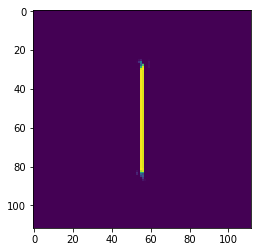

In [19]:
def plot_neuron_activation(activations, instance, index):
    plt.imshow(activations[instance, :, :, index])
    
plot_neuron_activation(layer_output, 2, 5)

## Plot activation responses 

In [61]:
def plot_layer_activations(figure_size, activations, instance):
    """ helper function to aggregate activation maps in a single plot.
    
    Args:
        figure_size: a tuple (width, height) for figure size.
        activations: the activation outputs from a layer (multiple image instances).
        instance: index for the image instance.
    """
    plt.figure(figsize=figure_size)
    size = activations.shape[3]
    for i in range(size):
        plt.subplot(int(size/5)+1, 5, i+1)
        plt.title("feature %d" % i)
        plt.imshow(activations[instance, :, :, i])

### activation maps from shallow layers

In [62]:
# get output from shallow layers 
get_shallow_layer_output = get_layer_output_function(model, layer_dict, "block2_conv2")
shallow_layer_output = get_shallow_layer_output([line_batch, 0])[0]

print(shallow_layer_output.shape)    # validate layer output 

#### features learnt from shallow layers 

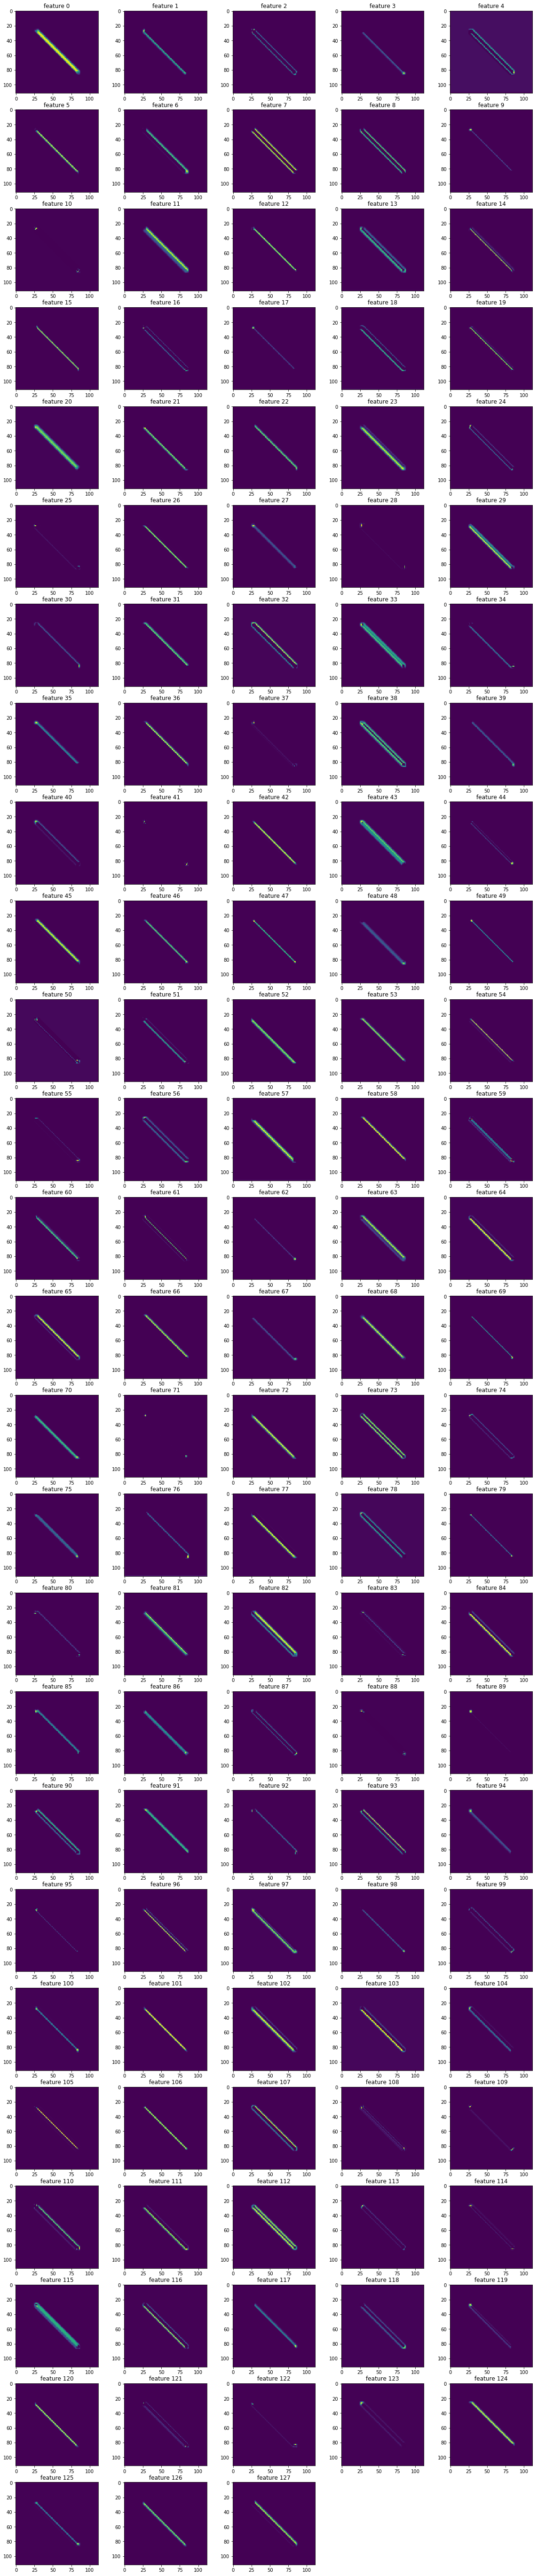

In [35]:
plot_layer_activations((20, 100), shallow_layer_output, 1)

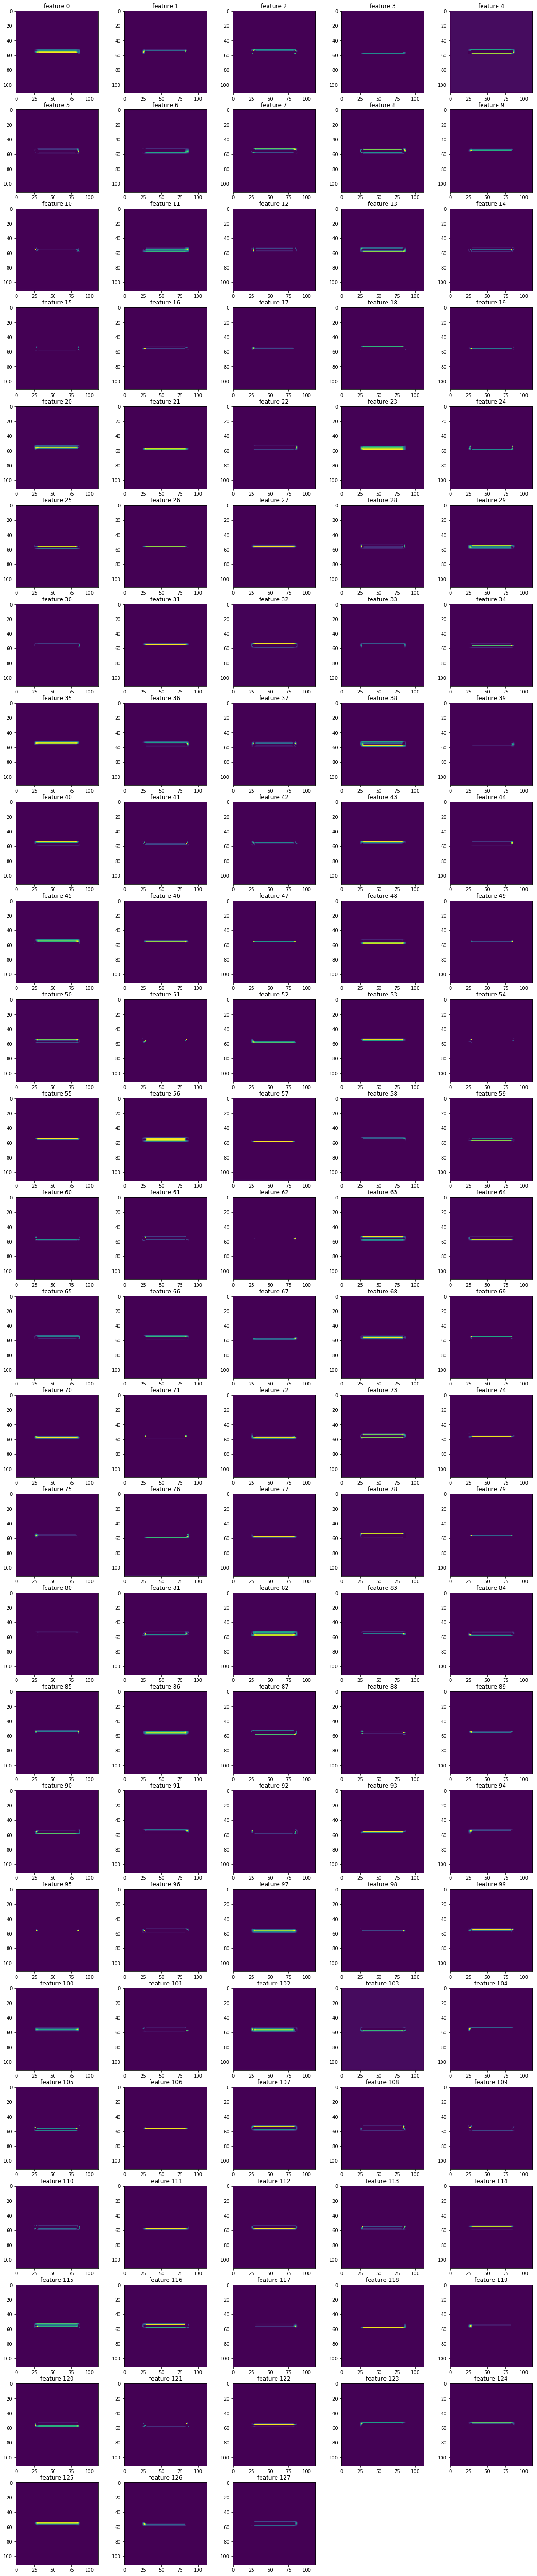

In [36]:
plot_layer_activations((20, 100), shallow_layer_output, 0)

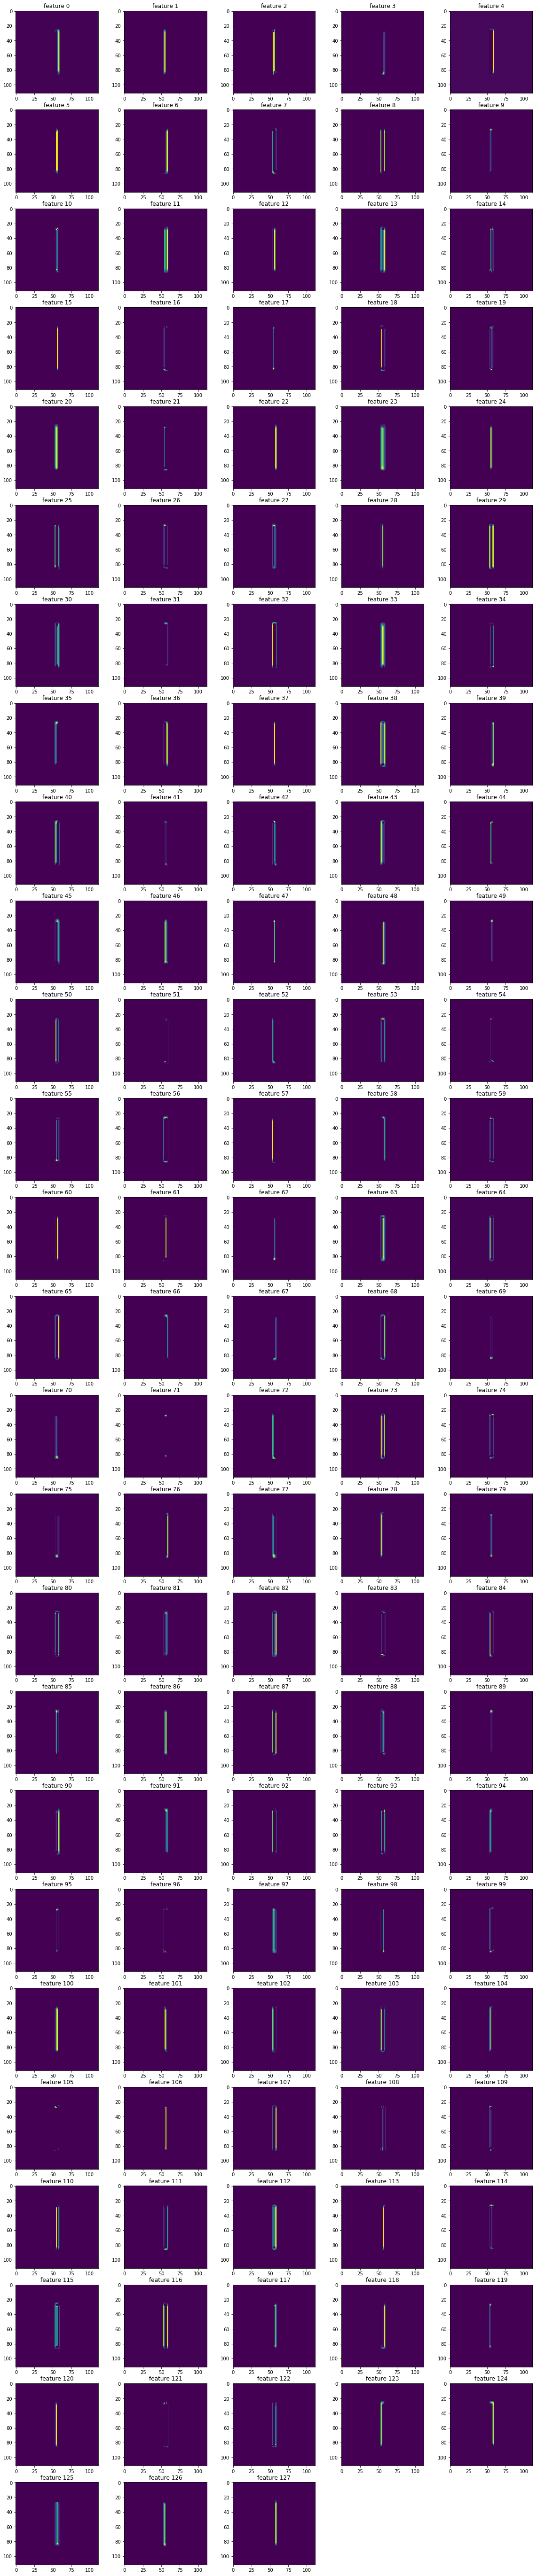

In [37]:
plot_layer_activations((20, 100), shallow_layer_output, 2)

### activation maps from deeper layers 

In [63]:
# get output from deeper layers
get_deeper_layer_output = get_layer_output_function(model, layer_dict, "block4_conv3")
deeper_layer_output = get_deeper_layer_output([line_batch, 0])[0]

print(deeper_layer_output.shape)    # validate layer output 

(5, 28, 28, 512)


#### features learnt from deeper layers

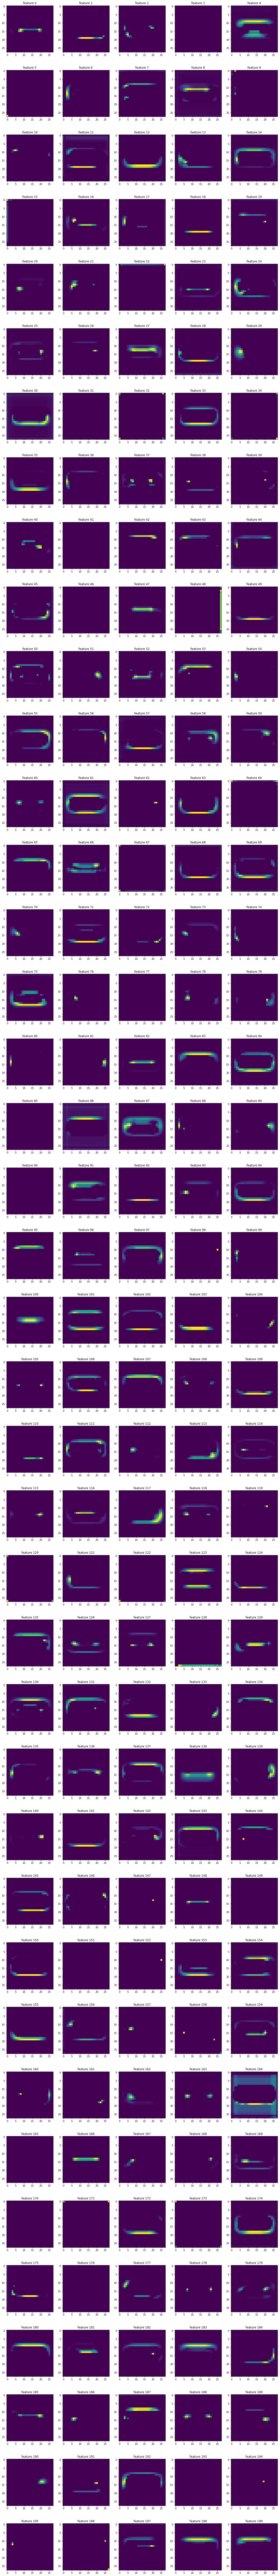

In [39]:
# take a subset of the output size (too many features to plot)
plot_layer_activations((20, 200), deeper_layer_output[:, :, :, :200], 0)

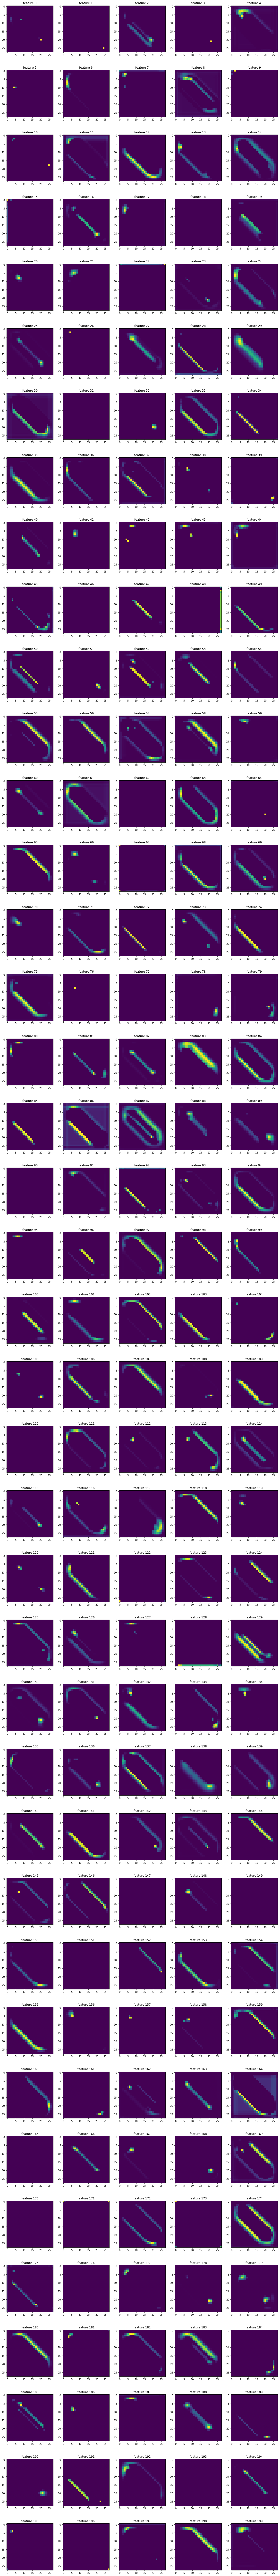

In [40]:
plot_layer_activations((20, 200), deeper_layer_output[:, :, :, :200], 1)

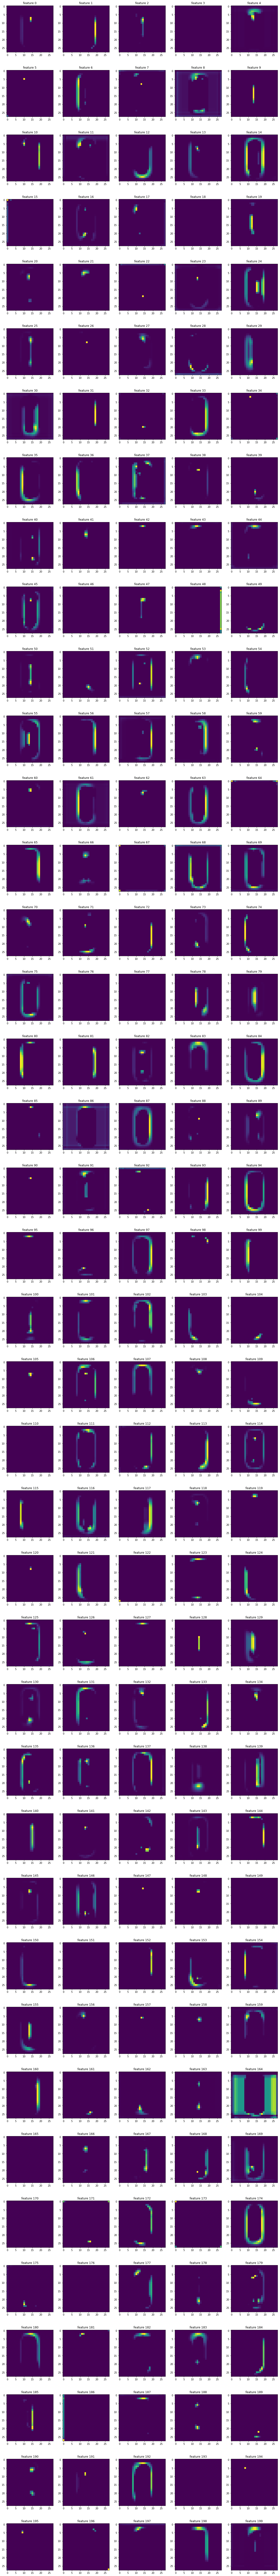

In [41]:
plot_layer_activations((20, 200), deeper_layer_output[:, :, :, :200], 2)

## Summary

Shallow layers learnt mostly elementary features such as end points, edges or straight lines. But deeper layers tend to pick up more complicated patterns and structures like rings, semi-circles or other combination of elementary shapes.

*** Try with other images and you will find out more about what those layers learnt. ***